### InceptionNet

InceptionNet[1] 也是诞生于 2014 年，值得一提的是，VGGNet 是当年 ImageNet 竞赛的亚军，而冠军则是本节要介绍的 InceptionNet。InceptionNet 的核心是它的基本单元 Inception 结构块，无论是 GoogleNet（即 InceptionNet v1）还是 InceptionNet 的后续版本 v2、v3、v4 都是基于 Inception 结构块搭建的网络。Inception 结构块如下图所示：

![](https://static.oschina.net/uploads/space/2018/0317/141520_31TH_876354.png)

InceptionNet 最初的设计思想是利用不同尺寸的卷积层和池化层进行横向组合来拓宽网络，使用全 0 填充让卷积、池化后的特征尺寸保持不变，再让通道进行相加，增加了网络对特征尺寸的适应性，但是这最初的思想会也带来一个问题，所有的卷积核都会在上一层的输出上直接做卷积运算，这会导致参数量和计算量过大。因此，又在此基础上**在卷积运算前、最大池化后加入了 $1\times1$ 的卷积层，来对网络参数进行降维**，改变输出特征的通道（channel）数，减低特征厚度，最终形成了上图的结构。

这时又有一个问题了，为什么加入一个 $1\times1$ 的卷积层可以达到降低特征厚度的效果呢？举例来说，假设上一层的网络输出为 $100\times100\times128$ ($高\times宽\times通道数$)，如果使用 32 个 $5\times5$ 的卷积核进行卷积运算（步长为 1，全 0 填充），那么输出就为 $100\times100\times32$（卷积核的个数决定了输出特征图的深度），那么此时卷积层的参数量就为 $32\times5\times5\times128=102400$（乘以 128 是因为卷积核的深度为 128，这由输入特征图的深度决定）；如果让上一层的输出先经过 32 个 $1\times1$ 卷积核的卷积运算，使新的输出为 $100\times100\times32$，再在其基础上用 32 个 $5\times5$ 的卷积核进行卷积运算，最终输出仍是 $100\times100\times32$，但是参数量就变为了 $32\times1\times1\times128+32\times5\times5\times32=29696$，仅为原参数的 $30%$ 左右，这就是小卷积核的降维作用。

从上图可以知道 Inception 结构块包含四个分支，从左到右分析：
 + 经过 $1\times1$ 卷积核输出到卷积连接器
 + 经过 $1\times1$ 卷积核配合 $3\times3$ 卷积核输出到卷积连接器
 + 经过 $1\times1$ 卷积核配合 $5\times5$ 卷积核输出到卷积连接器
 + 经过 $3\times3$ 最大池化核配合 $1\times1$ 卷积核输出到卷积连接器
 
送到卷积连接器的特征数据尺寸都是相同的，卷积连接器会把收到的这四路特征数据**按深度方向**拼接，形成 Inception 结构块的输出。显然，InceptionNet 模型的构建与 VGGNet 及之前的网络相比，不再是简单的纵向堆叠，而是通过增加网络的宽度来提升网络的能力。

介绍完了 Inception 结构块，那么整个 InceptionNet 的结构又是怎么样的呢？如果看了[原论文](https://arxiv.org/pdf/1409.4842.pdf)会发现 InceptionNet 的 v1 版本，又叫 GoogLeNet，是一个十分复杂的网络，仅网络层数就有 22 层，GoogLeNet 的网络配置如下表：

![](https://static.oschina.net/uploads/space/2018/0317/141605_c1XW_876354.png)

这里不贴网络结构图是因为太长了，可以去论文中查看。但是本节要实现的 InceptionNet 不会那么复杂，但仍然会利用 Inception 结构块实现一个精简版本的 InceptionNet。

+ [1] Szegedy C , Liu W , Jia Y , et al. Going Deeper with Convolutions[J]. 2014.

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras import Model

### Inception 结构块

Inception 结构块是一个 2 层的网络，此外对于卷积核来说，除了卷积核的大小不同之外，均采用了：
 + 全 0 填充（`padding='same'`）
 + 批标准化
 + ReLu 激活函数

因此只需要专门设定卷积核大小即可（四个 $1\times1$、两个$3\times3$、一个$5\times5$）

对于最大池化核：大小则为 $3\times3$，步长为 1，使用全 0 填充（`padding='same'`）。

最后的卷积连接器（Filter Concatenation）会把所有传过来的**特征数据按深度方向叠加**在一起。什么意思呢？比如上一层的输出深度为 16，那么经过四路特征数据的深度叠加，结果就是 $4\times16=64$。

In [2]:
# 对于使用了 BN 操作、ReLu激活函数的卷积核的封装
class ConvBNRelu(Model):
    def __init__(self, channel, kernel_size=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(channel, kernel_size, strides=strides,padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])
    
    def call(self, x):
        return self.model(x)

In [3]:
# Inception 结构块，使用上面的 ConvBNRelu 快速构建
class InceptionBlock(Model):
    def __init__(self, channel, strides=1):
        super(InceptionBlock, self).__init__()
        self.channel = channel
        self.strides = strides
        # 根据结构图，从左到右，有 4 列，从下往上（第一列除外）分 2 行，
        # 用于降维的 1x1 卷积核的步长由外部控制
        self.c1 = ConvBNRelu(channel, kernel_size=1, strides=strides) # 1x1 conv
        self.c2_1 = ConvBNRelu(channel, kernel_size=1, strides=strides) # 1x1 conv
        self.c2_2 = ConvBNRelu(channel, kernel_size=3, strides=1) # 3x3 conv
        self.c3_1 = ConvBNRelu(channel, kernel_size=1, strides=strides) # 1x1 conv
        self.c3_2 = ConvBNRelu(channel, kernel_size=5, strides=1) # 1x1 conv
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(channel, kernel_size=1, strides=strides) # 1x1 conv
    
    def call(self, x):
        # 注意块内是四个分支
        x1 = self.c1(x)
        
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        
        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        # 按深度方向叠加
        y = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return y

### 精简版 InceptionNet 网络结构

在 Inception 结构块的基础之上，接下来会实现一个 10 层的精简版 InceptionNet 来训练 CIFAR-10 数据集：**一层卷积层、四个 Inception 结构块（$4\times2$ 层）、一层全连接层**：

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout

 + **第一层**：卷积层：
   + C：使用 16 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B：使用批标准化 Batch Normalization
   + A：使用 ReLu 激活函数
   + P：不使用池化
   + D：不使用 Dropout
 + **第二、三层**：第一个 Inception 结构块
  + 用于降维的 $1\times1$ 的卷积核步长设为 2，输出特征图尺寸减半
 + **第四、五层**：第二个 Inception 结构块
 + 让输出特征图通道数×2（因为特征图尺寸已减半，所以这里让深度加深，**尽量保持特征抽取中信息的承载量一致**）
 + **第六、七层**：第三个 Inception 结构块
  + 用于降维的 $1\times1$ 的卷积核步长设为 2，输出特征图尺寸减半
 + **第八、九层**：第四个 Inception 结构块 
 + 对以上传过来的特征图数据使用一次全局平均池化 （Global Average Pooling）
 + **第十层**：全连接层
  + 10 个神经元
  + 使用 softmax 激活函数

In [4]:
class InceptionNet10(Model):
    def __init__(self, channel=16):
        super(InceptionNet10, self).__init__()
        self.channel = channel
        self.c1 = ConvBNRelu(self.channel) # 该函数的默认值符合该层设计
        self.block1 = InceptionBlock(self.channel, strides=2)
        self.block2 = InceptionBlock(self.channel, strides=1)
        self.channel *= 2
        self.block3 = InceptionBlock(self.channel, strides=2)
        self.block4 = InceptionBlock(self.channel, strides=1)
        self.p1 = GlobalAveragePooling2D()
        self.f1 = Dense(10, activation='softmax')
    
    def call(self, x):
        x = self.c1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.p1(x)
        y = self.f1(x)
        return y

In [5]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
# InceptionNet10
model = InceptionNet10()

In [7]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [8]:
# 设置断点续训
checkpoint_save_path = './checkpoint/VGGNet16.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [9]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [10]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 359s 7ms/sample - loss: 1.2178 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.6076
Epoch 2/5
50000/50000 [==============================] - 352s 7ms/sample - loss: 0.8775 - sparse_categorical_accuracy: 0.6911 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.6803
Epoch 3/5
50000/50000 [==============================] - 341s 7ms/sample - loss: 0.7350 - sparse_categorical_accuracy: 0.7423 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.6347
Epoch 4/5
50000/50000 [==============================] - 345s 7ms/sample - loss: 0.6488 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.7665 - val_sparse_categorical_accuracy: 0.7361
Epoch 5/5
50000/50000 [==============================] - 391s 8ms/sample - loss: 0.5843 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.7262


In [11]:
# 打印网络结构
model.summary()

Model: "inception_net10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu (ConvBNRelu)    multiple                  512       
_________________________________________________________________
inception_block (InceptionBl multiple                  10208     
_________________________________________________________________
inception_block_1 (Inception multiple                  13280     
_________________________________________________________________
inception_block_2 (Inception multiple                  43968     
_________________________________________________________________
inception_block_3 (Inception multiple                  52160     
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple              

In [12]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [13]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

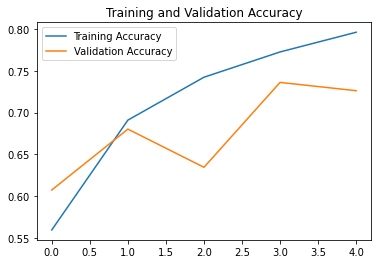

In [14]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

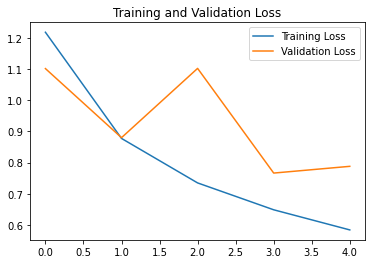

In [15]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()